In [19]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [20]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
RADI = torch.from_numpy(np.load(data_path + '/radi.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 200
NUM_HIDDEN = 32
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
DEVICE = 0


RECON_SIGMA = torch.ones(1) * 0.05
RADI = torch.ones(1) * 2.0
lg2pi = torch.log(torch.ones(1) * 2 * math.pi)

PATH = 'ag-phase2'

In [ ]:
from local_enc_angle_vonmises import *
from True_decoder import *

enc_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
dec_x = Dec_x(RADI, RECON_SIGMA, CUDA, DEVICE)

if CUDA:
    with torch.cuda.device(DEVICE):
        enc_angle.cuda()
optimizer =  torch.optim.Adam(list(enc_angle.parameters()), lr=LEARNING_RATE, betas=(0.9, 0.99))

In [4]:
from von_mises import *

In [31]:
vonmises = VonMises(torch.ones(1), torch.ones(1)* 1e-2)

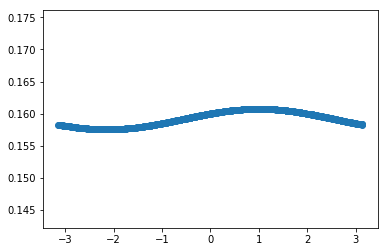

In [32]:
N = 1000
samples = vonmises.sample((N,))
pdfs = vonmises.log_prob(samples).exp()

plt.scatter(samples.data.numpy(), pdfs.data.numpy())

In [ ]:
import torch.nn.functional as F
def Update_angle(enc_angle, dec_x, ob, state, mu):
    q_angle, p_angle = enc_angle(ob, state, mu)
    log_q_angle = q_angle['angles'].log_prob.sum(-1)
    log_p_angle = p_angle['angles'].log_prob.sum(-1)
    angle = q_angle['angles'].value * 2 * math.pi
    log_recon = dec_x.forward(ob, state, angle, mu, idw_flag=False)
    log_w_f = log_recon + log_p_angle - log_q_angle
    w = F.softmax(log_w_f, 0).detach()
    eubo = (w * log_w_f).sum(0).sum(-1).mean()
    ess = (1. / (w**2).sum(0)).mean()
    return eubo, ess, q_angle

In [ ]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    EUBO = 0.0
    ESS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        state = STATE[batch_indices]
        mu = MU[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
        embed = shuffler(torch.cat((ob, state), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            with torch.cuda.device(DEVICE):  
                embed =embed.cuda()
                mu = mu.cuda()
        ob = embed[:, :, :, :2]
        state = embed[:, :, :, 2:]
        eubo, ess, _ = Update_angle(enc_angle, dec_x, ob, state, mu)
        ## gradient step
        eubo.backward()
        optimizer.step()  
        EUBO += eubo.detach()
        ESS += ess.detach()
    time_end = time.time()
    print('epoch=%d, eubo=%.4f, ess=%.4f (%ds)' % (epoch, EUBO / NUM_BATCHES, ESS / NUM_BATCHES, time_end - time_start))

In [ ]:
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
state = STATE[batch_indices]
mu = MU[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
angle_true = ANGLE[batch_indices]
embed = shuffler(torch.cat((ob, state, angle_true), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    with torch.cuda.device(DEVICE):  
        embed =embed.cuda()
        mu = mu.cuda()
ob = embed[:, :, :, :2]
state = embed[:, :, :, 2:-1]
angle_true = embed[:, :, :, -1].unsqueeze(-1)
eubo, ess, q_angle = Update_angle(enc_angle, dec_x, ob, state, mu)
angle = q_angle['angles'].value * 2 * math.pi
plot_angles(angle, angle_true, 15)